In [ ]:
pip install imblearn

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

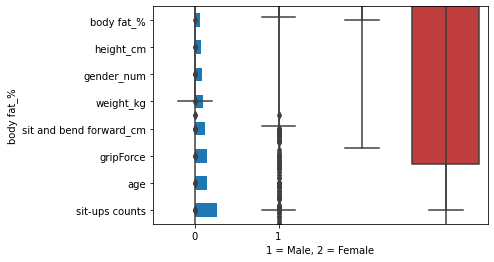

In [3]:
import boto3
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
import precision_recall_cutoff

### defining bucket###
s3=boto3.resource('s3')
bucket_name= 'dmw-448'
bucket = s3.Bucket(bucket_name)

### definging CSV ###
file_key = 'bodyPerformance.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')


# Reading the csv file and seperating columkns
performance = pd.read_csv(file_content_stream)

## Changing labels to numbers
performance['class_num'] = np.where(performance['class'] == 'A', 0,
                        np.where(performance['class'] == 'B', 1,
                        np.where(performance['class'] == 'C', 2,3)))

## Changing labels to numbers
performance['gender_num'] = np.where(performance['gender'] == 'M', 0,1)


## definging input and target variables
X = performance.drop(columns = ['class', 'gender', 'class_num'], axis = 1)
Y = performance['class_num']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

#Creating Box plots to get a baseline analysis of data
import seaborn as sns
sns.boxplot( x= performance['class_num'], y= performance['sit and bend forward_cm'] ).set_xlabel('1 = class A, 2= class B, 3= class C, 4= class D')

sns.boxplot( x= performance['class_num'], y= performance['sit-ups counts'] ).set_xlabel('1 = class A, 2= class B, 3= class C, 4= class D')

sns.boxplot( x= performance['gender_num'], y= performance['sit-ups counts'] ).set_xlabel('1 = Male, 2 = Female')

sns.boxplot( x= performance['gender_num'], y= performance['sit and bend forward_cm'] ).set_xlabel('1 = Male, 2 = Female')

sns.boxplot( x= performance['gender_num'], y= performance['body fat_%'] ).set_xlabel('1 = Male, 2 = Female')

#Variable importance with Random Forest Model
X = performance.drop(columns = ['class', 'gender', 'class_num'], axis = 1)
Y = performance['class_num']
model = RandomForestClassifier()
model.fit(X, Y)

(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(8)
   .plot(kind='barh'))

#Variable importance with AdaBoostClassifier Model
model = AdaBoostClassifier()
model.fit(X, Y)

(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(8)
   .plot(kind='barh')) 

## Engineering six features by using the strong heredity principle
performance['feature_1'] = performance['sit-ups counts'] * performance['sit and bend forward_cm']
performance['feature_2'] = performance['body fat_%'] * performance['sit-ups counts']
performance['feature_3'] = performance['body fat_%'] * performance['sit and bend forward_cm']
performance['feature_4'] = performance['sit-ups counts'] * performance['age']
performance['feature_5'] = performance['gripForce'] * performance['sit-ups counts']
performance['feature_6'] = performance['gripForce'] * performance['age']
performance.head()


########## RANDOMFOREST MODEL ###########


#Creating list for RandomForest results
RF_results = list()

#Creating loop for model 
for i in tqdm(range(0, 100)):
   #Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    #Building the random forest model
    RF = RandomForestClassifier(max_depth = 3, n_estimators = 500).fit(X_train, Y_train)
    
    #Extracting feature importances
    RF_results.append(RF.feature_importances_)
    
    
#Changing to data frame
RF_results = pd.DataFrame(RF_results)
RF_results.columns = X.columns


#computing averages and sorting importances
RF_results = pd.DataFrame(RF_results.apply(np.mean, axis = 0))
RF_results = pd.DataFrame({'Feature': RF_results.index, 'Importance': RF_results[0].values})
RF_results = RF_results.sort_values(by = 'Importance', ascending = False)
RF_results


########## ADABOOSTCLASSIFIER MODEL #############

# Defining variables
X = performance.drop(columns = ['class', 'gender', 'class_num'], axis = 1)
Y = performance['class_num']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

#Creating list for AdaBoostClassifier results
ADA_results = list()

#creating loop for model
for i in tqdm(range(0, 100)):
    #Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    #Building the random forest model
    Ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 500, learning_rate = 0.01).fit(X_train, Y_train)

    
    #Extracting feature importances
    ADA_results.append(Ada.feature_importances_)
    
    
#Changing to data frame
ADA_results = pd.DataFrame(ADA_results)
ADA_results.columns = X.columns


#computing averages and sorting importances
ADA_results = pd.DataFrame(ADA_results.apply(np.mean, axis = 0))
ADA_results = pd.DataFrame({'Feature': ADA_results.index, 'Importance': ADA_results[0].values})
ADA_results = ADA_results.sort_values(by = 'Importance', ascending = False)
ADA_results



#Appending both dataframes to findout variable_importance sum
Sums = pd.concat([RF_results, ADA_results]).groupby(['Feature']).sum().reset_index()
Sums = Sums.sort_values(by = 'Importance', ascending = False)
Sums


#Plotting Sums Results
df = pd.DataFrame({'Feature':['feature_1','sit and bend forward_cm', ' feature_4', 'feature_3', 'weight_kg',
                              'body fat_%', 'feature_5', 'sit-ups counts', 'gripForce', 'broad jump_cm', 'feature_6',
                              'feature_2', 'height_cm', 'age', 'gender_num', 'diastolic', 'systolic'], 'Importance':[0.459467,0.293268, 0.183902,0.162227,
                               0.141971,  0.112999, 0.112754,  0.097040, 0.086687, 0.068319,  0.052728,  0.050421, 0.046412, 0.040694 , 0.036505,
                                0.027819, 0.026789        ]})
ax = df.plot.barh(x='Feature', y='Importance', rot=0)

In [ ]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Defining variables and splitting data
X = performance[['feature_1', 'sit and bend forward_cm', 'feature_4', 'feature_3']]
Y = performance['class_num']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Standardizing the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
## Building the multi-classifier (using RF)
one_vs_all_RF = OneVsRestClassifier(estimator = RandomForestClassifier(n_estimators = 500, max_depth = 3)).fit(X_train, Y_train)
## Predicting on the test
one_vs_all_RF_pred = one_vs_all_RF.predict_proba(X_test)
one_vs_all_RF_pred = np.argmax(one_vs_all_RF_pred, axis = 1) + 1
## Building the multi-classifier (using SVM)
one_vs_all_svm = OneVsRestClassifier(estimator = SVC(kernel = 'rbf', probability = True)).fit(X_train, Y_train)
## Predicting on the test
one_vs_all_svm_pred = one_vs_all_svm.predict_proba(X_test)
one_vs_all_svm_pred = np.argmax(one_vs_all_svm_pred, axis = 1) + 1

#exporting csv
one_vs_all = pd.DataFrame({'ONE VS ALL': one_vs_all_svm_pred})
one_vs_all.to_csv('One_vs_all_svm.csv', index = False)

#exporting csv
one_vs_all = pd.DataFrame({'ONE VS ALL': one_vs_all_RF_pred})
one_vs_all.to_csv('One_vs_all_RF.csv', index = False)

# Building Random Forest Classifier model
one_v_all_RF = OneVsRestClassifier(estimator = RandomForestClassifier(n_estimators = 500, max_depth = 3)).fit(X_train, Y_train)

# Predicting on test dataset
one_v_all_RF_pred = one_v_all_RF.predict(X_test)

# Confusion Matrix
print(classification_report(Y_test, one_v_all_RF_pred))

one_v_rest_ada = OneVsRestClassifier(estimator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01)).fit(X_train, Y_train)

## Predicting on the test 
one_v_rest_ada_pred = one_v_rest_ada.predict(X_test)

## Computing the classification report 
print(classification_report(Y_test, one_v_rest_ada_pred))

# Building SVC model
one_vs_all_svm = OneVsRestClassifier(estimator = SVC(kernel = 'rbf', probability = True)).fit(X_train, Y_train)

## Predicting on the test 
one_vs_all_svm_pred = one_vs_all_svm.predict(X_test)

## Computing the classification report 
print(classification_report(Y_test, one_vs_all_svm_pred))



In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

#Defining variables and splitting data
X = performance[['feature_1', 'sit and bend forward_cm', 'feature_4', 'feature_3']]
Y = performance['class_num']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)


#Building svc model
one_vs_one_svc = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, Y_train)

## Predicting on the test 
one_vs_one_svc_pred = one_vs_one_svc.predict(X_test)

## Computing the classification report 
print(classification_report(Y_test, one_vs_one_svc_pred))

NameError: name 'performance' is not defined